## Phase 3 Project
Michal Ostrowski

In [225]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [226]:
# Load the dataset
Telecomdf = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

## Data cleaning

In [227]:
#Looking for null values
print(Telecomdf.isnull().sum())

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64


In [228]:
#No values appear to be null in the above cell

In [229]:
#Editing column names
Telecomdf = Telecomdf.rename(columns={'international plan': 'international_plan', 'voice mail plan': 'voice_mail_plan'})

In [230]:
#Looking for duplicates
print(Telecomdf.duplicated().sum())

0


No duplicates are present

In [231]:
#making alphabetical values numerical
Telecomdf['international_plan'] = np.where(Telecomdf['international_plan'] == 'yes', 1, 0)
Telecomdf['voice_mail_plan'] = np.where(Telecomdf['voice_mail_plan'] == 'yes', 1, 0)

In [232]:
Telecomdf['churn'] = Telecomdf['churn'].astype(str).replace({'True': 1, 'False': 0})

In [233]:
#creating a new column with total charges
Telecomdf = Telecomdf.assign(total_charge=lambda x: x['total day charge'] + x['total eve charge'] + x['total night charge'] + x['total intl charge'])

In [234]:
#removing state, they dont seem right as there are many states but only 3 area codes
Telecomdf.drop(columns=['state'], inplace=True)

## Starting Data Analysis

In [235]:
print(Telecomdf.describe())

       account length    area code  international_plan  voice_mail_plan  \
count     3333.000000  3333.000000         3333.000000      3333.000000   
mean       101.064806   437.182418            0.096910         0.276628   
std         39.822106    42.371290            0.295879         0.447398   
min          1.000000   408.000000            0.000000         0.000000   
25%         74.000000   408.000000            0.000000         0.000000   
50%        101.000000   415.000000            0.000000         0.000000   
75%        127.000000   510.000000            0.000000         1.000000   
max        243.000000   510.000000            1.000000         1.000000   

       number vmail messages  total day minutes  total day calls  \
count            3333.000000        3333.000000      3333.000000   
mean                8.099010         179.775098       100.435644   
std                13.688365          54.467389        20.069084   
min                 0.000000           0.000000     

In [237]:
# Define the regression formula
formula = 'churn ~ international_plan + voice_mail_plan'

# Fit the regression model
model = smf.ols(formula, data=Telecomdf).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     141.4
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           1.14e-59
Time:                        14:41:18   Log-Likelihood:                -1113.6
No. Observations:                3333   AIC:                             2233.
Df Residuals:                    3330   BIC:                             2251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1375      0

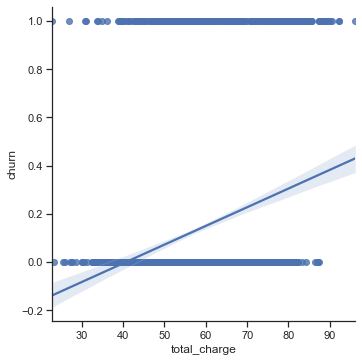

In [238]:
sns.lmplot(x='total_charge', y='churn', data=Telecomdf)

In [239]:
# Fit a multiple linear regression model
model = smf.ols(formula='total_charge ~ churn', data=Telecomdf).fit()

# Make predictions for a range of churn values
churn_range = pd.DataFrame({'churn': np.linspace(Telecomdf['churn'].min(), Telecomdf['churn'].max(), 100)})
predictions = model.predict(churn_range)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

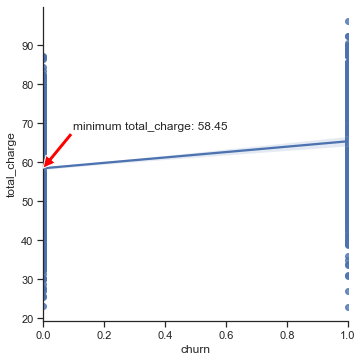

In [240]:
# Create a scatter plot with a multiple linear regression line
sns.lmplot(x='churn', y='total_charge', data=Telecomdf)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

# Annotate the plot with the minimum total_charge and churn values
plt.annotate(f'minimum total_charge: {predictions[min_index]:.2f}', xy=(min_churn, predictions[min_index]), xytext=(min_churn + 0.1, predictions[min_index] + 10), arrowprops={'facecolor': 'red'})

# Label the axes
plt.xlabel('churn')
plt.ylabel('total_charge')

# Show the plot
plt.show()

At this point I see that the point in dollars where people drew the line of when they would cancel their service.  That price was 58.45 dollars.
seeing this My first recommendation is going to be to create a monthly plan and charge 50.00 dollars


In [241]:
#create a column for the churn rate by dividing the number of churned accounts by the total number of accounts at each point in time
Telecomdf['churn_rate'] = Telecomdf.groupby('account length')['churn'].apply(lambda x: x.sum() / len(x))

Text(0.5, 1.0, 'The impact of Account Length on Churn Rate')

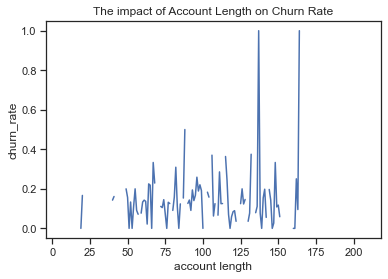

In [242]:
# plot the churn rate on the y-axis and the account length on the x-axis
sns.lineplot(x='account length', y='churn_rate', data=Telecomdf)
plt.title('The impact of Account Length on Churn Rate')

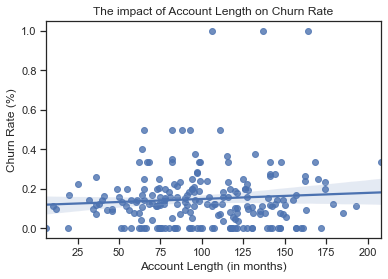

In [243]:
sns.regplot(x='account length', y='churn_rate', data=Telecomdf)
plt.title('The impact of Account Length on Churn Rate')
plt.xlabel('Account Length (in months)')
plt.ylabel('Churn Rate (%)')
plt.show()

At this point I am seeing that the churn rate gets much higher between 125 and 175 months.  My second suggestion is to add some sort of loyalty program where your cost goes down the higher your account length gets.

I will now be looking at the correlation between the ammount of service calls, and churn.  

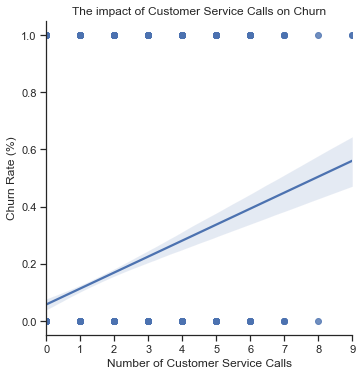

In [244]:
sns.lmplot(x='customer service calls', y='churn', data=Telecomdf)
plt.title('The impact of Customer Service Calls on Churn')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Churn Rate (%)')
plt.show()

Its clear that customers who suffer from having to call customer service (someone who has a problem) is more likely to leave this company.

Based off this I recommend we do more research into the areas that are more prone to customers calling customer service and look into what is causing these problems.  We need to update/upgrade infastructure possibly?

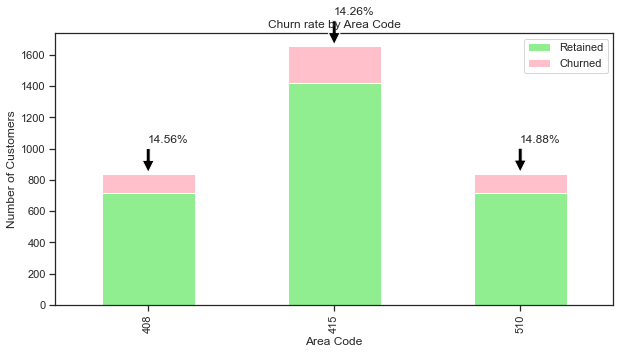

In [245]:
# calculate the percentage of customers that churned for each area code
Telecomdf['churn'] = Telecomdf['churn'].replace({0: 'No', 1: 'Yes'})
churn_by_area = Telecomdf.groupby(['area code', 'churn'])['customer service calls'].count().unstack().reset_index()
churn_by_area['churn rate'] = (churn_by_area['Yes']/(churn_by_area['Yes'] + churn_by_area['No']))*100

# create a stacked bar chart
ax = churn_by_area.plot(kind='bar', stacked=True, x='area code', y=['No', 'Yes'], color=['lightgreen', 'pink'],figsize=(10,5))
ax.set_xlabel('Area Code')
ax.set_ylabel('Number of Customers')
plt.legend(["Retained", "Churned"])
plt.title('Churn rate by Area Code')

for i in range(len(churn_by_area)):
    ax.annotate(str(round(churn_by_area.loc[i, 'churn rate'],2)) + '%', xy=(i, churn_by_area.loc[i, 'No'] + churn_by_area.loc[i, 'Yes']), xytext=(i, churn_by_area.loc[i, 'No'] + churn_by_area.loc[i, 'Yes'] + 200), 
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

people are leaving this company spread evenly over these 3 zipcodes, I recommend improving the quality of infastructure throughout all 3 areas, not only will it lower churn in short term, but will "future proof" the entire company and will stave off churn long term.

If we dont want to spend money on infastructure, we can at the very least see here that there is no difference between zipcodes so any changes we make should be company wide and not limited to one area.

In [246]:


customer_service_calls = Telecomdf['customer service calls']

# Define the regression formula
formula = 'churn_rate ~ total_charge + customer_service_calls'

# Fit the regression model
model = smf.ols(formula, data=Telecomdf).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             churn_rate   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8236
Date:                Tue, 10 Jan 2023   Prob (F-statistic):              0.440
Time:                        14:41:38   Log-Likelihood:                 97.385
No. Observations:                 212   AIC:                            -188.8
Df Residuals:                     209   BIC:                            -178.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

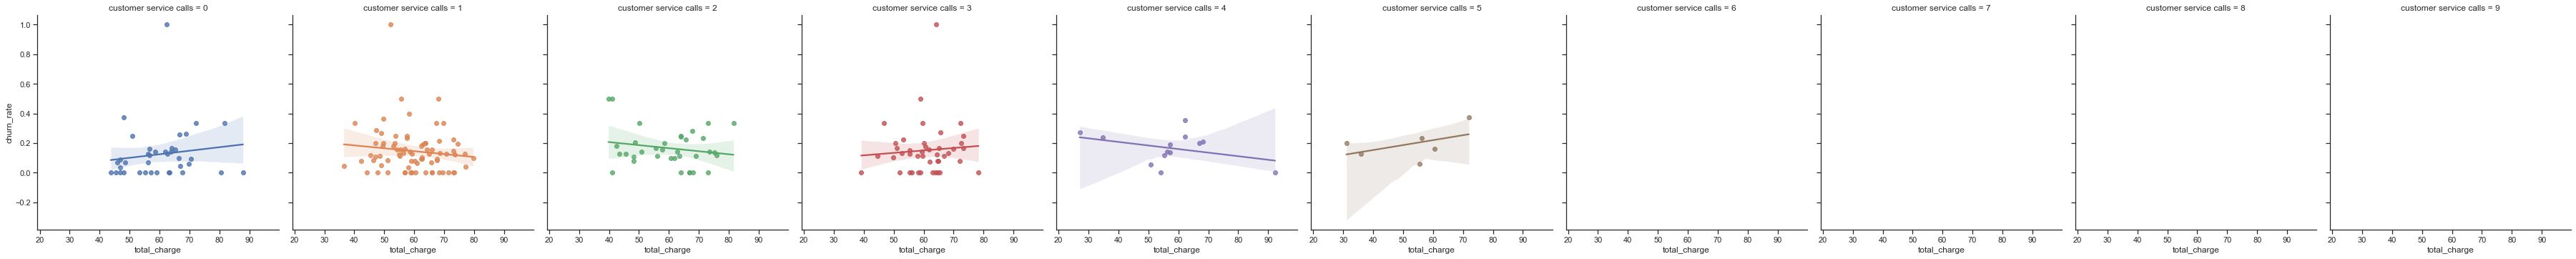

In [247]:
sns.lmplot(x='total_charge', y='churn_rate', hue='customer service calls', data=Telecomdf, col='customer service calls')